# Import relevant libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# xgboost
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# PCA
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import PCA
from kneed import KneeLocator

# logreg / rfe
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# to display all rows in dataframes
pd.set_option('display.max_rows', None) 

# Load data

In [2]:
df = pd.read_csv("../data/grouped_data.csv")
X_train = pd.read_csv("../data/X_train_final.csv")
X_test = pd.read_csv("../data/X_test_final.csv")
y_train = pd.read_csv("../data/y_train_final.csv")
y_test = pd.read_csv("../data/y_test_final.csv")

In [3]:
# one hot encode the categories
features_nominal = ['order_1', 'order_2', 'order_3', 'order_6', 'order_7']
X_train = pd.get_dummies(X_train, columns = features_nominal)
X_test = pd.get_dummies(X_test, columns = features_nominal)

# Feature Selection

In [4]:
impt_feat = []

## XGB feature importance

In [6]:
# fit model to training data
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, xgb.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame(feats.items(), columns=['Feature', 'Importance'])
#.rename(columns={0: 'importance'})
importances = importances.sort_values(by = ['Importance'], ascending = False)
impt_feat.extend(importances.Feature.iloc[0:30].tolist())

In [7]:
impt_feat

['order_2_G',
 'count_G',
 'order_6_T',
 'order_7_A',
 'mean_current_2_median',
 'sd_current_2_median',
 'mean_current_2_std',
 'mean_current_3_std',
 'sd_current_2_min',
 'diff_mean_current_2_median',
 'order_7_G',
 'order_6_A',
 'mean_current_3_median',
 'order_7_T',
 'sd_current_2_std',
 'diff_mean_current_2_max',
 'mean_current_2_min',
 'diff_mean_current_1_min',
 'diff_mean_current_1_median',
 'mean_current_2_max',
 'mean_current_3_min',
 'mean_current_1_median',
 'order_2_A',
 'relative_position',
 'sd_current_3_median',
 'mean_current_1_max',
 'order_7_C',
 'mean_current_1_std',
 'count_T',
 'order_1_T']

## PCA dimensionality reduction

Remove categorical features

In [8]:
df_pca = df.drop(columns = ['label', 'sevenmers', 'gene_id', 'transcript_id', 'order_1', 'order_2', 'order_3', 'order_6', 'order_7'])

In [9]:
_ , p_value = calculate_bartlett_sphericity(df_pca)
p_value

0.0

In [10]:
_, kmo_score = calculate_kmo(df_pca)
kmo_score 

d:\y4s1\DSA4262\dsa4262-gnomes\dsa4262-venv\lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.8367589042644792

As p-value < 0.5 and kmo score > 0.5, PCA is suitable on the dataframe.

In [11]:
fa = FactorAnalyzer(n_factors = 10, method = 'principal', rotation='varimax')
fa.fit(df_pca)
eigenvalues, _ = fa.get_eigenvalues()
variances = fa.get_factor_variance()

Text(0, 0.5, 'Proportion of Variance Explained by PC')

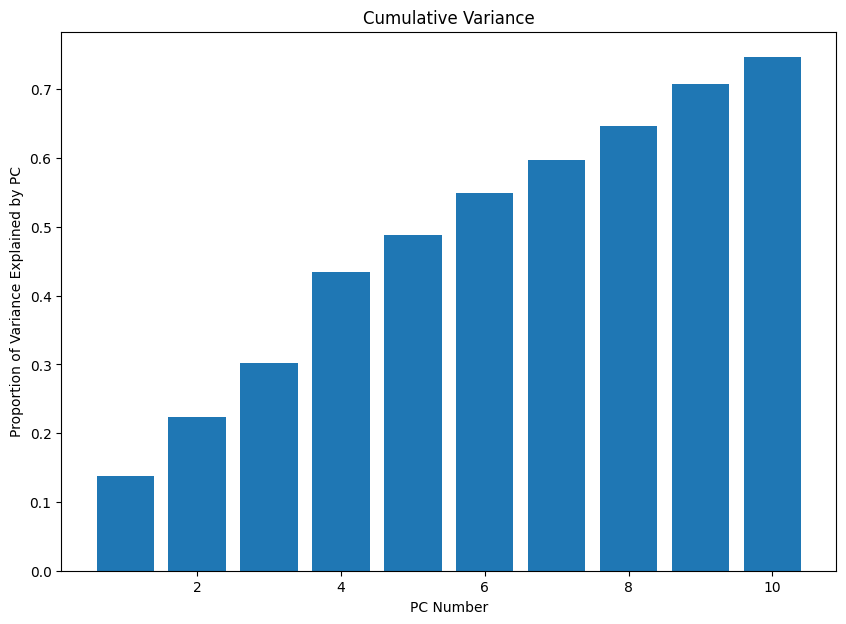

In [12]:
x = list(range(1,11))
plt.figure(figsize=(10, 7)) 
plt.bar(x,variances[2])
plt.title('Cumulative Variance')
plt.xlabel('PC Number')
plt.ylabel('Proportion of Variance Explained by PC')

In [13]:
def evaluate_pcs(num_of_pcs,data):
    def encode_vals(x):
        if x <= -0.7 or x >= 0.7:
            return x
        else:
            return("")    
    # REMARK: we use 'principal' method and 'varimax' rotation in the FactorAnalyzer function.
    f = FactorAnalyzer(n_factors=num_of_pcs, method = 'principal',rotation='varimax')
    f.fit(data)
    loadings = pd.DataFrame(f.loadings_).set_index(data.columns)
    loadings = loadings.applymap(encode_vals)
    loadingcols= list(loadings.columns)
    newcols = {}
    for i in loadingcols:
        newcols[i] = "PC" + str(i+1)
    loadings.rename(columns = newcols,inplace=True)
    return loadings

# The following function generates the rotation matrix. Recall that we use
# this matrix to determine if the PCs generated are easily understandable and appropriate.
# The argument "num_of_pcs" specifies, the number of PCs we wish to generate.

In [14]:
def variance_explained(num_of_pcs,data):
    # REMARK: we use 'principal' method and 'varimax' rotation in the FactorAnalyzer function.
    f = FactorAnalyzer(n_factors=num_of_pcs, method = 'principal',rotation='varimax')
    f.fit(data)
    return f.get_factor_variance()[2][num_of_pcs-1]

# The following function calculates the variance explained by the specified desired number of PCs.

Chose 9 PCs as it explains >70% of the variance

In [15]:
variance_explained(9, df_pca)

0.7219339478857085

In [16]:
evaluate_pcs(9,df_pca)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
transcript_position,,,,,,,,,
dwelling_time_1_min,,,,,,,,,
dwelling_time_1_max,,,,,,,,,0.794011
dwelling_time_1_median,,,,,,,,,0.757115
dwelling_time_1_std,,,,,,,,,0.849693
sd_current_1_min,,,,,,,,,
sd_current_1_max,,,,,,,,,
sd_current_1_median,,0.827938,,,,,,,
sd_current_1_std,,,,,,,,,
mean_current_1_min,,0.744913,,,,,,,


Drop the columns that are not in any PCs as they are not as important.

In [18]:
new_df = df.drop(columns = ['transcript_position', 'dwelling_time_1_min',
                           'sd_current_1_min', 'sd_current_1_max', 'sd_current_1_std',
                           'mean_current_1_std', 'dwelling_time_2_min', 'dwelling_time_2_median',
                           'sd_current_2_min', 'mean_current_2_min', 'mean_current_2_max', 'mean_current_2_median',
                           'mean_current_2_std', 'dwelling_time_3_min', 'sd_current_3_min',
                           'mean_current_3_std', 'diff_dwelling_time_1_median', 'diff_dwelling_time_1_std',
                           'diff_dwelling_time_2_median', 'diff_sd_current_1_min', 'diff_sd_current_1_median',
                           'diff_mean_current_1_max', 'diff_mean_current_1_std', 'diff_mean_current_2_min',
                           'diff_mean_current_2_median', 'relative_position', 'count_A', 'count_C', 'count_G', 'count_T'])

In [19]:
cols2keep_pca = new_df.columns
impt_feat.extend(new_df.columns)

## RFE Recursive Feature Elimination

## 

In [22]:
logreg = LogisticRegression(max_iter=1000)

In [23]:
rfe3 = RFE(logreg, n_features_to_select=30)
rfe3 = rfe3.fit(X_train, y_train.values.ravel())

## 

In [24]:
# cols remaining
cols_keep = X_train.columns.values[rfe3.support_]
impt_feat.extend(cols_keep)

In [25]:
impt_feat

['order_2_G',
 'count_G',
 'order_6_T',
 'order_7_A',
 'mean_current_2_median',
 'sd_current_2_median',
 'mean_current_2_std',
 'mean_current_3_std',
 'sd_current_2_min',
 'diff_mean_current_2_median',
 'order_7_G',
 'order_6_A',
 'mean_current_3_median',
 'order_7_T',
 'sd_current_2_std',
 'diff_mean_current_2_max',
 'mean_current_2_min',
 'diff_mean_current_1_min',
 'diff_mean_current_1_median',
 'mean_current_2_max',
 'mean_current_3_min',
 'mean_current_1_median',
 'order_2_A',
 'relative_position',
 'sd_current_3_median',
 'mean_current_1_max',
 'order_7_C',
 'mean_current_1_std',
 'count_T',
 'order_1_T',
 'gene_id',
 'transcript_id',
 'sevenmers',
 'order_1',
 'order_2',
 'order_3',
 'order_6',
 'order_7',
 'label',
 'dwelling_time_1_max',
 'dwelling_time_1_median',
 'dwelling_time_1_std',
 'sd_current_1_median',
 'mean_current_1_min',
 'mean_current_1_max',
 'mean_current_1_median',
 'dwelling_time_2_max',
 'dwelling_time_2_std',
 'sd_current_2_max',
 'sd_current_2_median',
 's

In [26]:
len(impt_feat)

105